# 과정

### [1] 데이터 전처리

1. 한글 및 공백을 제외한 모든 문자 제거 -> 한글만 남기겠다.
2. 띄어쓰기 규칙
3. mecab 객체를 활용해 형태소 단위로 문장을 나눈다(tokenzing)
4. 불용어 제거하기

### [2] Tokenize => keras 기본 토크나이저 이용

1. threshold = 2로 지정(빈도수는 최소 2번 이상인 단어)

### [3] 모델

1. LSTM => accuracy: 0.8472
2. CNN => acc: 0.8443


### 네이버 영화 리뷰 감성 분석

In [ ]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
BASIC_PATH = "/home/ai-sjjy/workspace/juyoung/AI/project/dataset/"

In [ ]:
TOTAL_RATINGS = '/rating.txt'
TRAIN_RATINGS = '/ratings_train.txt'
TEST_RATINGS = '/ratings_test.txt'

## [1] 데이터 분석

#### [1-] 파일 크기, 데이터 개수 확인

In [ ]:
print("파일 크기 : ")
for file in os.listdir(BASIC_PATH):
    if 'txt' in file and 'zip' not in file:
        print(file.ljust(30) + str(round(os.path.getsize(BASIC_PATH+"/"+file) / 100000, 2)) + 'KB')

파일 크기 : 
ratings_test.txt              48.93KB
rating.txt                    195.15KB
stop_words.txt                0.02KB
ratings_train.txt             146.29KB


In [ ]:
train_data = pd.read_csv(
    BASIC_PATH + TRAIN_RATINGS, header = 0, delimiter = '\t', quoting=3
)

In [ ]:
train_data.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
print("전체 학습데이터 개수 : {}".format(len(train_data)))

전체 학습데이터 개수 : 150000


In [ ]:
test_data = pd.read_csv(
    BASIC_PATH + TEST_RATINGS, header = 0, delimiter = '\t', quoting=3
)

In [ ]:
test_data.head(5)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
print("전체 테스트 데이터 개수 : {}".format(len(test_data)))

전체 테스트 데이터 개수 : 50000


#### [1-2] 리뷰의 길이 확인

In [ ]:
train_length = train_data['document'].astype('str').apply(len)

In [ ]:
train_length.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

/home/ai-sjjy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


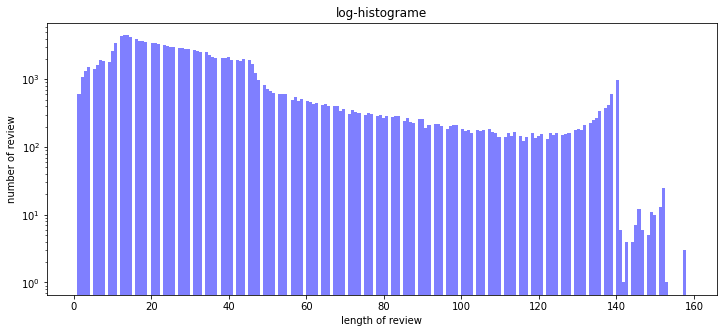

In [ ]:
plt.figure(figsize=(12, 5))
plt.hist(train_length, bins=200, alpha=0.5, color='b', label='word')
plt.yscale('log', nonposy='clip')
plt.title('log-histograme')
plt.xlabel('length of review')
plt.ylabel('number of review')
plt.show()

#### [1-3] 긍정 부정 데이터 분포

/home/ai-sjjy/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

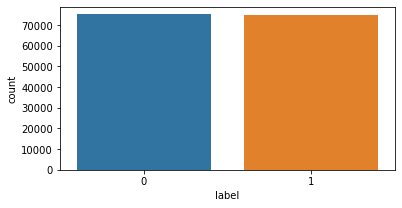

In [ ]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['label'])

In [ ]:
print("긍정 리뷰 개수 : {}".format(train_data['label'].value_counts()[1]))
# 긍정 : 74825
print("부정 리뷰 개수 : {}".format(train_data['label'].value_counts()[0]))
# 부정 : 75170

긍정 리뷰 개수 : 74827
부정 리뷰 개수 : 75173


#### [1-4] 각 리뷰의 단어 개수 분포

/home/ai-sjjy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  


Text(0, 0.5, 'number of reviews')

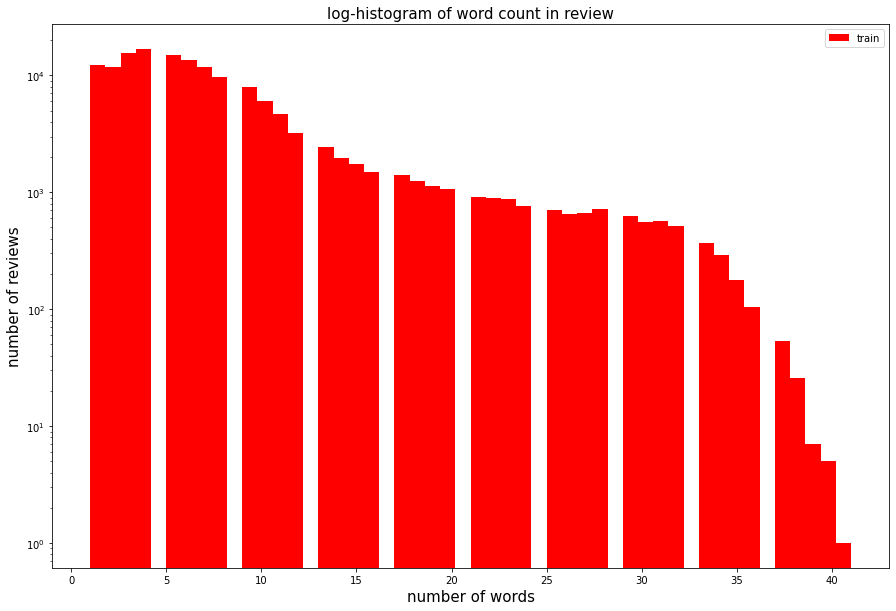

In [ ]:
train_word_counts = train_data['document'].astype('str').apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='r', label='train')
plt.title('log-histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('number of words', fontsize=15)
plt.ylabel('number of reviews', fontsize=15)

#### [1-5] 특수문자

In [ ]:
qmarks = np.mean(train_data['document'].astype('str').apply(lambda x: '?' in x))
fullstop = np.mean(train_data['document'].astype('str').apply(lambda x: '.' in x))
numbers = np.mean(train_data['document'].astype('str').apply(lambda x: max([y.isdigit() for y in x])))


print("물음표 있는 질문 : {:.2f}%".format(qmarks * 100))
print("마침표 있는 질문 : {:.2f}%".format(fullstop * 100))
print("숫자가 있는 질문 : {:.2f}%".format(numbers * 100))

물음표 있는 질문 : 8.25%
마침표 있는 질문 : 51.76%
숫자가 있는 질문 : 13.62%


#### [1-6] 결측치 확인

In [ ]:
train_data.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [ ]:
test_data.isnull().sum()

id          0
document    3
label       0
dtype: int64

In [ ]:
train_data[train_data['document'].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [ ]:
test_data[test_data['document'].isnull()]

,id,document,label
5746,402110,NaN,1
7899,5026896,NaN,0
27097,511097,NaN,1


* document가 없는 데이터는 필요 없다 => drop!

In [ ]:
train_data = train_data[~train_data['document'].isnull()]

In [ ]:
test_data = test_data[~test_data['document'].isnull()]

In [ ]:
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [ ]:
test_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

#### [1-7] 필요없는 속성 제거
=> id 제거

In [ ]:
train_data = train_data[['document', 'label']]
test_data = test_data[['document', 'label']]

## [2] 데이터 전처리

In [ ]:
import numpy as np
import pandas as pd
import os
import re
import json

from konlpy.tag import Mecab

from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from hanspell import spell_checker

from pykospacing import Spacing
spacing = Spacing()

mecab = Mecab() #형태소 분석기 선언


In [ ]:
stop_words = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

#### [2-1] 데이터 전처리 진행 1

In [ ]:
def preprocessing(review, spell, remove_stopwords = False, stop_words = []):    
    # 1. 한글 및 공백을 제외한 모든 문자 제거 -> 한글만 남기겠다.
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ - | \\s]", "", review)
    
    # 2. 띄어쓰기 규칙
    review_text = spacing(review_text)
    
    # 3. mecab 객체를 활용해 형태소 단위로 문장을 나눈다(tokenzing)
    word_review = mecab.morphs(review_text)
    
    # 4. 불용어 제거하기
    if remove_stopwords:
        word_review = [token for token in word_review if not token in stop_words]
    
    return word_review

In [ ]:
clean_train_review = []

from tqdm import tqdm

for review in tqdm(train_data['document']):
    clean_train_review.append(preprocessing(review, False, remove_stopwords = True, stop_words = stop_words))

100%|██████████| 149995/149995 [1:09:30<00:00, 35.96it/s]


In [ ]:
print("전체 리뷰 개수 : ", len(clean_train_review))
print("띄어쓰기 이상한 리뷰 제거한 개수 :", len([clean for clean in clean_train_review if clean]))

전체 리뷰 개수 :  149995
띄어쓰기 이상한 리뷰 제거한 개수 : 148669


In [ ]:
for idx, clean in enumerate(clean_train_review):
    if clean == None: continue
    if clean == []:
        clean_train_review[idx] = None
    else:
        clean_train_review[idx] = " ".join(clean)

In [ ]:
clean_test_review = []

for review in tqdm(test_data['document']):
    clean_test_review.append(preprocessing(review, False, remove_stopwords = True, stop_words = stop_words))

100%|██████████| 49997/49997 [23:09<00:00, 35.99it/s]


In [ ]:
print("전체 리뷰 개수 : ", len(clean_test_review))
print("띄어쓰기 이상한 리뷰 제거한 개수 :", len([clean for clean in clean_test_review if clean]))

전체 리뷰 개수 :  49997
띄어쓰기 이상한 리뷰 제거한 개수 : 49549


In [ ]:
for idx, clean in enumerate(clean_test_review):
    if clean == None: continue
    if clean == []:
        clean_test_review[idx] = None
    else:
        clean_test_review[idx] = " ".join(clean)

#### [2-2] 띄어쓰기 이상한 리뷰 제거

In [ ]:
train_data['document'] = clean_train_review

In [ ]:
train_data.isnull().sum()

document    1326
label          0
dtype: int64

In [ ]:
train_data = train_data[~train_data['document'].isnull()]

In [ ]:
train_data.isnull().sum()

document    0
label       0
dtype: int64

In [ ]:
print("전체 리뷰 개수 : ", len(train_data))

전체 리뷰 개수 :  148669


In [ ]:
train_data

,document,label
0,아 더빙 진짜 짜증 나 네요 목소리,0
1,흠 포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나,1
2,너무 재 밓었다 그래서 보 것 을 추천 한다,0
3,교도소 이야기 구먼 솔직히 재미 없 다 평점 조정,0
4,사이몬 페그 익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했...,1
...,...,...
149995,인간 문제지 소 뭔 죄 인가,0
149996,평점 너무 낮 아서,1
149997,이게 뭐 요 한국인 거들 먹거리 고 필리핀 혼혈 착하 다,0
149998,청춘 영화 최고봉 방황 우울 했 던 날 자화상,1


In [ ]:
test_data['document'] = clean_test_review

In [ ]:
test_data.isnull().sum()

document    448
label         0
dtype: int64

In [ ]:
test_data = test_data[~test_data['document'].isnull()]

In [ ]:
test_data.isnull().sum()

document    0
label       0
dtype: int64

In [ ]:
print("전체 리뷰 개수 : ", len(test_data))

전체 리뷰 개수 :  49549


In [ ]:
train_data.to_csv(BASIC_PATH + 'clean_train.csv', index=False)
test_data.to_csv(BASIC_PATH + 'clean_test.csv', index=False)

### [2-2] 기본 Tokenizer

* Tokenizer 사용

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
X_train = train_data['document'].tolist()
X_train = [x.split() for x in X_train]
y_train = np.array(list(train_data['label'].tolist()))

In [ ]:
X_test = test_data['document'].tolist()
X_test = [x.split() for x in X_test]
y_test = np.array(list(test_data['label'].tolist()))

In [ ]:
X_train[11]

['볼',
 '때',
 '마다',
 '눈물',
 '나',
 '서',
 '죽',
 '겠',
 '다',
 '년',
 '대',
 '향수',
 '자극',
 '허진호',
 '감성',
 '절',
 '제',
 '멜로',
 '달인',
 '다']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'다': 1, '영화': 2, '고': 3, '하': 4, '을': 5, '보': 6, '게': 7, '지': 8, '없': 9, '있': 10, '좋': 11, '나': 12, '만': 13, '었': 14, '너무': 15, '는데': 16, '어': 17, '안': 18, '봤': 19, '적': 20, '로': 21, '기': 22, '거': 23, '정말': 24, '아': 25, '음': 26, '것': 27, '재밌': 28, '네요': 29, '지만': 30, '같': 31, '진짜': 32, '네': 33, '했': 34, '에서': 35, '점': 36, '수': 37, '않': 38, '았': 39, '인': 40, '되': 41, '면': 42, 'ㅋㅋ': 43, '말': 44, '연기': 45, '내': 46, '주': 47, '최고': 48, '던': 49, '평점': 50, '이런': 51, '해': 52, '어요': 53, '할': 54, '왜': 55, '겠': 56, 'ㅋㅋㅋ': 57, '스토리': 58, '습니다': 59, '생각': 60, '그': 61, '듯': 62, '드라마': 63, '아니': 64, '때': 65, '싶': 66, '사람': 67, '더': 68, '본': 69, '감동': 70, '배우': 71, '재미': 72, '보다': 73, '함': 74, '까지': 75, '라': 76, '볼': 77, '알': 78, '뭐': 79, '내용': 80, '중': 81, '만들': 82, '감독': 83, '그냥': 84, '지루': 85, '재미있': 86, '시간': 87, '잼': 88, '년': 89, '였': 90, '서': 91, '사랑': 92, '쓰레기': 93, '못': 94, '요': 95, '냐': 96, '번': 97, '야': 98, '니': 99, '하나': 100, '라고': 101, '면서': 102, '다시': 103, '재미없': 104, '나오': 105, '작품': 10

In [ ]:
print("총 단어 개수 :", len(tokenizer.word_index))

총 단어 개수 : 44610


In [ ]:
threshold = 2 # 빈도 수는 2번이상인 단어 기준
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 44610
등장 빈도가 1번 이하인 희귀 단어의 수: 17516
단어 집합에서 희귀 단어의 비율: 39.264738847791975
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.8547012717560656


In [ ]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 27095


In [ ]:
tokenizer = Tokenizer(vocab_size) # index 번호 부여가 빈도수 기반으로 했기 때문에 해당 vocab까지 자르기
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))

[25, 492, 32, 215, 12, 29, 706]
라벨:  0
1번째 리뷰 문장 길이:  7


##### 빈 샘플 제거

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

148588
148588


/home/ai-sjjy/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### [2-2-2] 임베딩 최대 길이 지정

In [ ]:
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  13.664822824611253
문장길이 최대 :  83
문장길이 표준편차 :  11.56651844564856


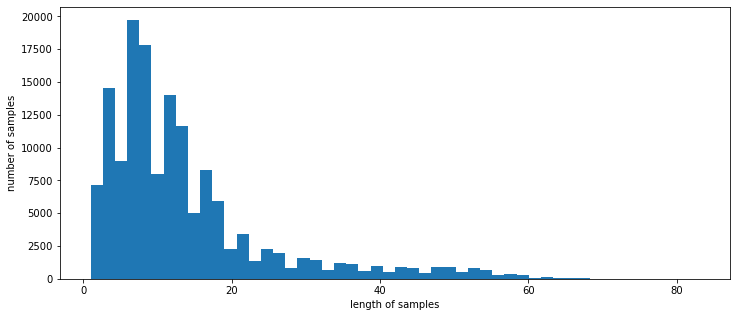

In [ ]:
plt.figure(figsize=(12, 5))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens) + 4
max_len = int(max_tokens)
print('pad_sequences maxlen : ', max_len)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  40
전체 문장의 0.9476523819377501%가 maxlen 설정값 이내에 포함됩니다. 


#### [2-2-3] 패딩

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
# 데이터셋 정제 후 데이터셋 shape 확인
print(X_train.shape)
print(X_test.shape)

(148588, 40)
(49549, 40)


In [ ]:
data_config = {
    'max_len' : max_len,
    'vocab_size' : vocab_size
}

In [ ]:
import json

json.dump(data_config, open(BASIC_PATH + 'data_configs.json', 'w'), ensure_ascii=False)

## [3] train data split 진행

In [ ]:
from sklearn.model_selection import train_test_split # 데이터 셋 분할

RANDOM_SEED = 42
TEST_SPLIT = 0.2

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=TEST_SPLIT, random_state=RANDOM_SEED)

In [ ]:
print(X_train.shape)
print(X_val.shape)

(118870, 40)
(29718, 40)


In [ ]:
X_train[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0, 16210,  1199,     5,  7644,
           4,     7,   170,     2], dtype=int32)

## [4] 모델 설정 및 훈련

### [4-1] LSTM 모델

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.layers import Dropout, Conv1D, GlobalMaxPooling1D, Input, Flatten, Concatenate

In [ ]:
lstm = Sequential()
lstm.add(Embedding(vocab_size, 100))
lstm.add(LSTM(128))
lstm.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('lstm_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = lstm.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=64, # 512, 100, 60 
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks = [es, mc])

Epoch 1/20
1858/1858 [==============================] - 58s 31ms/step - loss: 0.3824 - accuracy: 0.8276 - val_loss: 0.3440 - val_accuracy: 0.8486
Epoch 2/20
1858/1858 [==============================] - 57s 31ms/step - loss: 0.2829 - accuracy: 0.8802 - val_loss: 0.3480 - val_accuracy: 0.8471
Epoch 3/20
1858/1858 [==============================] - 58s 31ms/step - loss: 0.2282 - accuracy: 0.9070 - val_loss: 0.3690 - val_accuracy: 0.8523
Epoch 4/20
1858/1858 [==============================] - 57s 31ms/step - loss: 0.1833 - accuracy: 0.9275 - val_loss: 0.3989 - val_accuracy: 0.8499
Epoch 5/20
1858/1858 [==============================] - 58s 31ms/step - loss: 0.1460 - accuracy: 0.9430 - val_loss: 0.4696 - val_accuracy: 0.8491
Epoch 00005: early stopping


In [ ]:
results = lstm.evaluate(X_test, y_test, verbose=2)

print(results)

1549/1549 - 7s - loss: 0.4703 - accuracy: 0.8472
[0.47033604979515076, 0.8472219705581665]


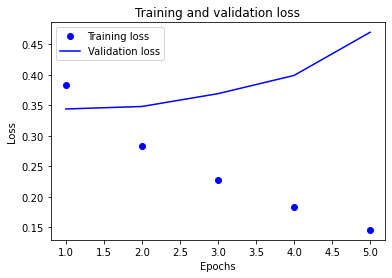

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
## 모델 저장
lstm.save(BASIC_PATH + 'lstm_model.h5')

### [4-2] CNN 모델

In [ ]:
embedding_dim = 128
dropout_prob = (0.5, 0.8)
num_filters = 128

model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_prob[0])(z)

In [ ]:
conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)


In [ ]:
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_prob[1])(z)
z = Dense(128, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('cnn_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
cnn = Model(model_input, model_output)
cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

history = cnn.fit(X_train, y_train, batch_size = 64, \
          epochs=10, validation_data = (X_val, y_val), verbose=1, callbacks=[es, mc])

Epoch 1/10
1858/1858 [==============================] - 51s 27ms/step - loss: 0.4345 - acc: 0.7903 - val_loss: 0.3665 - val_acc: 0.8426

Epoch 00001: val_acc improved from -inf to 0.84259, saving model to cnn_model.h5
Epoch 2/10
1858/1858 [==============================] - 50s 27ms/step - loss: 0.3417 - acc: 0.8543 - val_loss: 0.3538 - val_acc: 0.8478

Epoch 00002: val_acc improved from 0.84259 to 0.84780, saving model to cnn_model.h5
Epoch 3/10
1858/1858 [==============================] - 51s 27ms/step - loss: 0.3072 - acc: 0.8723 - val_loss: 0.3489 - val_acc: 0.8503

Epoch 00003: val_acc improved from 0.84780 to 0.85033, saving model to cnn_model.h5
Epoch 4/10
1858/1858 [==============================] - 51s 27ms/step - loss: 0.2795 - acc: 0.8856 - val_loss: 0.3521 - val_acc: 0.8480

Epoch 00004: val_acc did not improve from 0.85033
Epoch 5/10
1858/1858 [==============================] - 50s 27ms/step - loss: 0.2599 - acc: 0.8938 - val_loss: 0.3597 - val_acc: 0.8479

Epoch 00005: val

In [ ]:
results = cnn.evaluate(X_test, y_test, verbose=2)

print(results)

1549/1549 - 3s - loss: 0.3763 - acc: 0.8443
[0.3762645423412323, 0.8442552089691162]


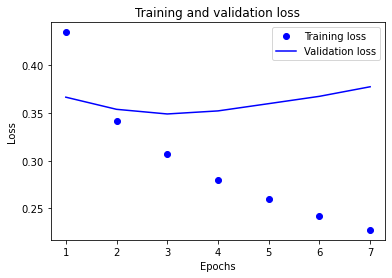

In [ ]:
history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
## 모델 저장
cnn.save(BASIC_PATH+'cnn_model.h5')

### [4-3] CNN-LSTM 모델

## [5] 리뷰 예측

In [ ]:
def sentiment_predict(model,new_sentence):
    new_sentence = preprocessing(new_sentence, False, remove_stopwords = True, stop_words = stop_words)
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict(lstm, '이 영화 개꿀잼 ㅋㅋㅋ')
sentiment_predict(cnn, '이 영화 개꿀잼 ㅋㅋㅋ')

99.69% 확률로 긍정 리뷰입니다.

99.96% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict(lstm,'아 너무 노잼이다')
sentiment_predict(cnn,'아 너무 노잼이다')

99.97% 확률로 부정 리뷰입니다.

98.68% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict(lstm,'아 너무 감동 받았어요ㅠㅠ')
sentiment_predict(cnn,'아 너무 감동 받았어요ㅠㅠ')

99.28% 확률로 긍정 리뷰입니다.

96.46% 확률로 긍정 리뷰입니다.

